In [1]:
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

C:\Users\Vikas Salunke\anaconda3\envs\time_series\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
store = pd.read_excel(r'C:\Users\Vikas Salunke\Desktop\Data Science\CocaCola_Sales_Rawdata.xlsx')
store

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [3]:
store.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [4]:
quarter=['Q1','Q2','Q3','Q4']
n=store['Quarter'][0]
n[0:2]

store['quarter']=0

In [5]:
for i in range(42):
    n=store['Quarter'][i]
    store['quarter'][i]=n[0:2]

In [6]:
dummy=pd.DataFrame(pd.get_dummies(store['quarter']))

In [7]:
coco=pd.concat((store,dummy),axis=1)
t= np.arange(1,43)
coco['t']=t
coco['t_square']=coco['t']*coco['t']

In [8]:
log_Sales=np.log(coco['Sales'])
coco['log_Sales']=log_Sales

<AxesSubplot:>

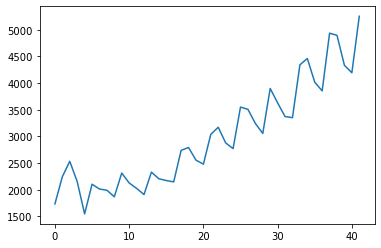

In [9]:
train= coco.head(38)
test=coco.tail(6)
coco.Sales.plot()

In [10]:
import statsmodels.formula.api as smf

#linear model
linear= smf.ols('Sales~t',data=train).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test['t'])))
rmselin=np.sqrt((np.mean(np.array(test['Sales'])-np.array(predlin))**2))
rmselin

397.99879655609715

In [11]:
quad=smf.ols('Sales~t+t_square',data=train).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test[['t','t_square']])))
rmsequad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predquad))**2))
rmsequad

475.18258285165814

In [12]:
expo=smf.ols('log_Sales~t',data=train).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test['t'])))
predexp
rmseexpo=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

496.22687291511977

In [13]:
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
predadd
rmseadd=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predadd))**2))
rmseadd

1776.5575216072716

In [14]:
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
predaddlinear

rmseaddlinear=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

449.72580304665036

In [15]:
addquad=smf.ols('Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test[['t','t_square','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddquad))**2))
rmseaddquad

264.7295149897615

In [16]:
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

1883.9571112361816

In [17]:
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

244.08432245486992

In [18]:
mul_quad= smf.ols('log_Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test[['t','t_square','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

481.88078564438445

In [19]:
data={'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}
data

{'Model': 0    rmse_mul_quad
 1          rmseadd
 2    rmseaddlinear
 3      rmseaddquad
 4         rmseexpo
 5          rmselin
 6          rmsemul
 7        rmsemulin
 8         rmsequad
 dtype: object,
 'Values': 0     481.880786
 1    1776.557522
 2     449.725803
 3     264.729515
 4     496.226873
 5     397.998797
 6    1883.957111
 7     244.084322
 8     475.182583
 dtype: float64}

In [20]:
Rmse=pd.DataFrame(data)
Rmse

,Model,Values
0,rmse_mul_quad,481.880786
1,rmseadd,1776.557522
2,rmseaddlinear,449.725803
3,rmseaddquad,264.729515
4,rmseexpo,496.226873
5,rmselin,397.998797
6,rmsemul,1883.957111
7,rmsemulin,244.084322
8,rmsequad,475.182583


<AxesSubplot:xlabel='Sales'>

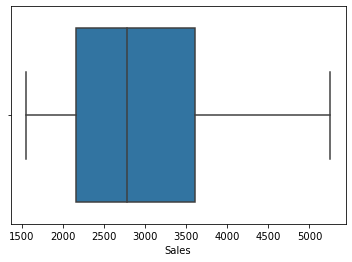

In [21]:
sns.boxplot("Sales",data=store)

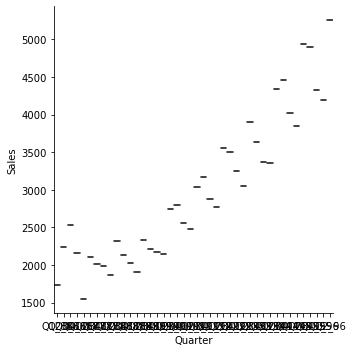

In [22]:
sns.factorplot("Quarter","Sales",data=store,kind="box")

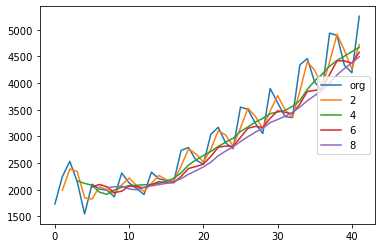

In [23]:
store.Sales.plot(label="org")
for i in range(2,10,2):
    store["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=5)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time

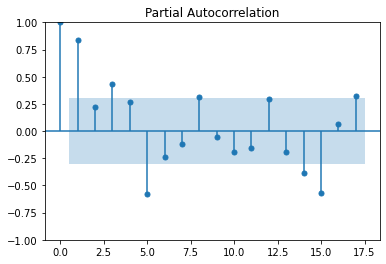

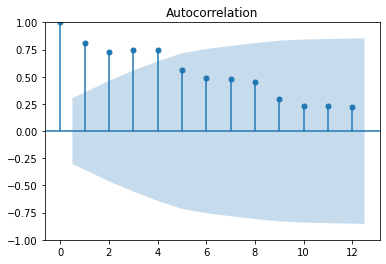

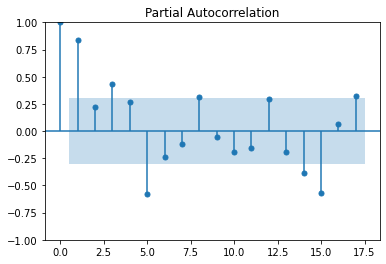

In [25]:
tsa_plots.plot_acf(store.Sales,lags=12)
tsa_plots.plot_pacf(store.Sales)

In [26]:
Train = store.head(46)
Test =store.tail(14)

In [27]:
def MAPE(pred,org):
    temp = np.abs((pred-org))*100/org
    return np.mean(temp)

In [28]:
ses_model = SimpleExpSmoothing(Train["Sales"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales)

10.237927098913259

In [29]:
hw_model = Holt(Train["Sales"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales)

11.505456694953438

In [30]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales)

3.4636983675434343

In [31]:
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales)

2.449635005144361

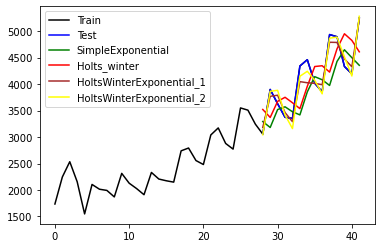

In [32]:
plt.plot(Train.index, Train["Sales"], label='Train',color="black")
plt.plot(Test.index, Test["Sales"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.legend(loc='best')